In [1]:
!git clone https://github.com/kanadn/diht.git

Cloning into 'diht'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 99 (delta 16), reused 16 (delta 4), pack-reused 60
Unpacking objects: 100% (99/99), 2.27 MiB | 9.00 MiB/s, done.


Install required modules...

In [2]:
#!git clone https://github.com/facebookresearch/diht
%cd diht
!pip install -r requirements.txt
!pip install -e .  # To install as an editable package
!pip install Pillow

/kaggle/working/diht
Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 14.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 69.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 526.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 M

These following models are available in the DiHT code...

In [3]:
import diht
print(diht.available_models())

['diht_vitb16_224px', 'diht_vitb32_224px', 'diht_vitl14_224px', 'diht_vitl14_336px']


Let us perform a sample image to text retrieval task...

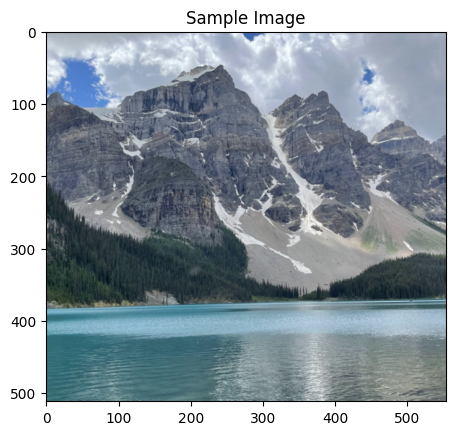

In [27]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Sample Image")
image = mpimg.imread("infer_image.png")
plt.imshow(image)
plt.show()

In [28]:
import torch

from diht import model_zoo
from PIL import Image


text_tokenizer, image_transform, model = model_zoo.load_model(
    "diht_vitl14_336px", is_train=False
)

if torch.cuda.is_available():
  model.cuda()
  image = Image.open("infer_image.png").convert("RGB")
  image = image_transform(image).unsqueeze(0).cuda()
  text_captions = ["a mountain", "a beach", "a desert"]
  text = text_tokenizer(text_captions).cuda()

else:
  image = Image.open("infer_image.png").convert("RGB")
  image = image_transform(image).unsqueeze(0)
  text_captions = ["a mountain", "a beach", "a desert"]
  text = text_tokenizer(text_captions)

with torch.no_grad():
    image_features, text_features, logit_scale = model(image, text)
    logits_per_image = logit_scale * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(f"text captions: {text_captions}")
print(f"text caption probs: {probs}")

text captions: ['a mountain', 'a beach', 'a desert']
text caption probs: [[0.99370664 0.0051402  0.00115325]]


So the model was able to identify the scene. Sample code is working, now let's do some tinkering...

In [5]:
text_captions2 = ["a mountain", "a lake", "a mountain and a lake"]

if torch.cuda.is_available():
  texts = text_tokenizer(text_captions2).cuda()
else:
  texts = text_tokenizer(text_captions2)

with torch.no_grad():
    image_features, text_features, logit_scale = model(image, texts)
    logits_per_image = logit_scale * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(f"text captions: {text_captions2}")
print(f"text caption probs: {probs}")

text captions: ['a mountain', 'a lake', 'a mountain and a lake']
text caption probs: [[0.01392788 0.01522736 0.9708448 ]]


The model seems to be smart :)  
It successfully identified a combination of mountain and a lake.

Now let's import Google's [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset using [Hugging Face](https://huggingface.co/datasets/conceptual_captions)  
Since the dataset contains just the image URLs, we need to fecth the actual images. This might take a lot of time.    
The following code stores the dataset into a map and was modified based on the original [DiHT code repository](https://github.com/facebookresearch/diht)

In [6]:
!pip install datasets

Set dataset range to validate...

In [15]:
gcc_from_index, gcc_to_index = 13000, 13500

In [16]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import json
import os

from typing import Callable, Tuple, Union

import PIL.Image
from torch.utils.data import Dataset
from datasets import load_dataset

from datasets.utils.file_utils import get_datasets_user_agent
import urllib
from torchvision.datasets.folder import find_classes, make_dataset

import numpy as np

import torch
import torch.nn.functional as F

from diht import model_zoo

from torch.utils.data import DataLoader
from tqdm import tqdm

class ImageSingleCaptionDataset(Dataset):
    r"""Generic class for image-caption datasets where each image is associated with
        a single caption.
    Methods:
    --------
    __getitem__(index): Tuple
        Return a tuple (image, captions). Both are preprocessed with
        respective transforms.
    len(): int
        Return the number of samples.
    Attributes:
    number_of_captions: int
        Return the number of captions in the dataset.
    """

    def __init__(
        self,
        name: str,
        split: str,
        transform: Callable = None,
    ) -> None:
        r"""Constructor for ImageMultiCaptionDataset.
        Parameters:
        -----------
        split: str
            The split (train or val or test).
        transform: Callable
            An image transformation.
        Returns:
        --------
        None
        """
        self._name = name
        self._split = split
        self._transform = transform
        self._load_data()

    def fetch_single_image(self, image_url, timeout=None, retries=0):
        USER_AGENT = get_datasets_user_agent()
        for _ in range(retries + 1):
            try:
                request = urllib.request.Request(
                    image_url,
                    data=None,
                    headers={"user-agent": USER_AGENT},
                )
                with urllib.request.urlopen(request, timeout=timeout) as req:
                    image = PIL.Image.open(io.BytesIO(req.read()))
                break
            except Exception:
                image = None
        return image
    
    def fetch_images(self, batch, num_threads, timeout=None, retries=0):
        fetch_single_image_with_args = partial(self.fetch_single_image, timeout=timeout, retries=retries)
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
        
        return batch
    
    def _load_data(self) -> None:
        # Huggingface code to load the dataset
        dset = load_dataset("conceptual_captions")
        dset_val = dset[self._split].select(range(gcc_from_index, gcc_to_index))  # Add .select(range(100)) to select the first 100 examples in validation set
        
        num_threads = 30

        dset_val = dset_val.map(self.fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

        processed_data = self._prepare_data_from_dict(dset_val)
        
        self._text = processed_data["captions"]
        self._txt2img = processed_data["txt2img"]
        self._img2txt = processed_data["img2txt"]
        self._data = processed_data["image_captions_data"]
        self._number_of_captions = int(sum(len(captions) for _, captions in self._data))

    def _prepare_data_from_dict(self, dataset):
        text = []
        txt2img = []
        img2txt = []
        image_captions_data = []
        img_count = 0
        # Here since each image has only one caption, we don't need to keep track of text_id and img_id
        for index, dset_dict in enumerate(dataset):
            if dset_dict["image"] is not None:
              image_i = dset_dict["image"]
              captions_i = dset_dict["caption"]
              text.append(dset_dict["caption"])
              txt2img.append(img_count)        
              img2txt.append(img_count)
              image_captions_data.append((image_i, captions_i))
              img_count += 1
            else:
              continue

        return {
            "captions": text,
            "txt2img": txt2img,
            "img2txt": img2txt,
            "image_captions_data": image_captions_data,
        }

    def __len__(self) -> int:
        r"""Return number of images in the dataset.
        Parameters
        ----------
        None
        Returns
        -------
        len: int
            Number of images in the dataset.
        """
        return len(self._data)

    @property
    def number_of_captions(self) -> int:
        r"""Return number of captions in the dataset.
        Parameters
        ----------
        None
        Returns
        -------
        number_of_captions: int
            Number of captions in the dataset.
        """
        return self._number_of_captions

    # This method is used by the dataloader to get the data, so keep it as it is
    def __getitem__(self, index: int) -> Union[Tuple, None]:
        r"""Return sample as tuple (image, index).
        We only return image and index because the captions could be of varying size
        and it could break default collates.
        The class implements _load_caption to handle loading captions.
        Parameters:
        -----------
        index: int
            The index of the sample.
        Returns:
        --------
        image: array_like
            The image for the `index` sample.
        index: int
            The index of the sample.
        Exception handling:
        -------------------
        If an exception is raised during dataloading,
        this function returns `None`.
        """
        image = self._load_image(index)
        return image, index

    def _load_image(self, index: int) -> Tuple:
      # TODO: Convert image to RGB
      image = self._data[index][0]
      image = image.convert("RGB")
      if self._transform is not None:
          image = self._transform(image)
      return image

    def _load_caption(self, index):
        caption = self._data[index][1]
        return caption

    # def _load_text(self, index: int) -> Tuple:
    #     captions = self._load_captions(index)
    #     return captions, self._img2txt[index]

    def _load_item(self, index: int) -> Tuple:
        image = self._load_image(index)
        captions = self._load_caption(index)
        return image, captions
    

class GCC(ImageSingleCaptionDataset):
    r"""The Google Conceptual Captions dataset.
    Webpage: https://ai.google.com/research/ConceptualCaptions/
    """

    def __init__(
        self,
        split: str,
        transform: Callable = None,
    ) -> None:
        r"""Constructor for GCC dataset.
        Parameters:
        -----------
        root: str
            Path where train and val split are saved.
        split: str
            The split (train or val or test).
        transform: Callable
            An image transformation.
        Returns:
        --------
        None
        """
        super().__init__(
            name="gcc",
            split=split,
            transform=transform,
        )

    def __repr__(self) -> str:
        return "\n".join(
            [
                "GCC(",
                f"  split={self._split},",
                f"  n_images={self.__len__()},",
                f"  n_captions={self.number_of_captions}"
                f"  transform={self._transform}",
                ")",
            ]
        )

Set the model and image transform...

In [10]:
MODEL_NAME = "diht_vitl14_336px"  # replace with the model you want to evaluate
TEMPLATE = "a photo of {}."
  
# get tokenizer, transform, model, eval dataset and dataloader
print(f"Load model {MODEL_NAME} ...")
text_tokenizer, image_transform, model = model_zoo.load_model(
    MODEL_NAME, is_train=False)

if torch.cuda.is_available():
  model.cuda()

Load model diht_vitl14_336px ...


The following cell will take some time to run...

In [17]:
gcc_dataset = GCC(split="validation", transform=image_transform)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [18]:
# gcc_dataloader = DataLoader(
#     dataset=gcc_dataset,
#     batch_size=32,
#     num_workers=1,
# )

gcc_dataloader = DataLoader(
    dataset=gcc_dataset,
    batch_size=32,
)

In the below cell we will extract image and caption features...

In [19]:
# Updated for GCC dataset
def extract_features(model, text_tokenizer, eval_dataset, eval_dataloader):
    all_image_features = []
    all_text_features = []
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            images, image_idxs = batch[0], batch[1]
            image_features = model.encode_image(images.cuda()) # model.encode_image(images.cuda())
            image_features = F.normalize(image_features, dim=-1)
            all_image_features.append(image_features.detach().cpu())
            for imidx in image_idxs.tolist():
                caption = eval_dataset._load_caption(imidx)
                caption = TEMPLATE.format(caption)
                caption = text_tokenizer(caption)
                text_features = model.encode_text(caption.cuda())  # model.encode_text(captions.cuda())
                text_features = F.normalize(text_features, dim=-1)
                all_text_features.append(text_features.detach().cpu())
    return (
        torch.cat(all_image_features),
        torch.cat(all_text_features),
    )

# compute image features
print("Extract features for GCC ...")
(
    gcc_image_features,
    gcc_text_features
) = extract_features(model, text_tokenizer, gcc_dataset, gcc_dataloader)

Extract features for GCC ...


100%|██████████| 13/13 [00:32<00:00,  2.48s/it]


In [20]:
print(gcc_image_features.shape)
print(gcc_text_features.shape)

torch.Size([395, 768])
torch.Size([395, 768])


Now that we have all the features, we can calculate Recall@1...

In [21]:
def compute_recall(
    scores_i2t,
    scores_t2i,
    txt2img,
    img2txt,
    k=[1, 5, 10],
):
    """Compute retrieval recall metrics."""
    # image-to-text
    ranks = np.zeros(scores_i2t.shape[0])
    for index, score in enumerate(scores_i2t):
        inds = np.argsort(score)[::-1]
        i2t_curr_rank_arr = np.where(inds == img2txt[index])[0]
        i2t_curr_rank = i2t_curr_rank_arr[0]
        ranks[index] = i2t_curr_rank
    print(f"ranks for image-to-text: {ranks}")
    # overall: compute image retrieval recall
    trs = {}
    for topk in k:
        trs[topk] = len(np.where(ranks < topk)[0]) / len(ranks)

    # text-to-image
    ranks = np.zeros(scores_t2i.shape[0])
    for index, score in enumerate(scores_t2i):
        inds = np.argsort(score)[::-1]
        t2i_curr_rank_arr = np.where(inds == txt2img[index])[0]
        t2i_curr_rank = t2i_curr_rank_arr[0]
        ranks[index] = t2i_curr_rank
    print(f"ranks for text-to-image: {ranks}")
    # overall: compute image retrieval recall
    irs = {}
    for topk in k:
        irs[topk] = len(np.where(ranks < topk)[0]) / len(ranks)
    return trs, irs

Evaluate image-to-text and text-to-image retrieval and calculate the recall...

In [22]:
def evaluate_retrieval(image_features, text_features, txt2img, img2txt):
    # compute similarity: image2text (i2t) and text2image (t2i)
    sim_i2t = image_features @ text_features.t()
    sim_t2i = sim_i2t.t()
    # evaluate image-text matching (itm)
    i2t, t2i = compute_recall(
        sim_i2t.numpy(),
        sim_t2i.numpy(),
        txt2img,
        img2txt,
        k=[1],
    )
    return i2t, t2i

In [23]:
gcc_i2t, gcc_t2i = evaluate_retrieval(
        gcc_image_features,
        gcc_text_features,
        gcc_dataset._txt2img,
        gcc_dataset._img2txt,
    )

ranks for image-to-text: [  0.   0.   0.   0.   0. 248.   0.   0.   0.   0.  64.   0.   0.   6.
   1.   1.   0.  89.   1.   2.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 107.   0.   0.   0.  77.   0.   0.   0.   3.   0.   0.   0.
   0.   0.  10.   0.   0.   0.   0.  17.  50.   0.   0.  62.  94.   0.
   0.   0.   3.   0.   0.   0.   0.   0.   1.   0.   0.   0.  80. 271.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   5.   2.   0.   0.   0.   0.   0.   0.   0.   1.  38.   4.   0.  44.
   0.   8.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  74.
   0.   0.  19.   0.   0.   0.   0. 105.   0.   0.   0.   0.   1.   0.
   0.   0.   4.  14.   3.   0.   0.   0.   0.   0.   0. 137.   0.  86.
  33.   0.  10. 325.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 169.   0.   0.   0.   0.   3.   0.   0.   0.   0.   3. 169.
   0.   0.   3.   6.   0.   0.   2.   0.   0.  56.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   3.   0.  95.   0.  

In [24]:
print(f"GCC T2I r@1 for {MODEL_NAME}: {100*gcc_t2i[1]:.1f}")
print(f"GCC I2T r@1 for {MODEL_NAME}: {100*gcc_i2t[1]:.1f}")

GCC T2I r@1 for diht_vitl14_336px: 73.4
GCC I2T r@1 for diht_vitl14_336px: 75.2


So we observed recall of **73.4 for text-to-image** retrieval and **75.2 for image-to-text retrieval**